In [1]:
%load_ext autoreload
%autoreload 2
%aimport peaks

# Introduction 

`peaks` is a collection of analysis tools for the loading, processing and display of spectroscopic and diffraction data, with a core focus on tools for angle-resolved photoemission, LEED, RHEED, and some other related techniques. It also includes various functions for efficient log keeping. 

:::{tip}
`peaks` builds heavily on :class:`xarray`. The user is *strongly* recommended to consult the extensive documentation and tutorials available on the [xarray website](https://docs.xarray.dev/en/stable/). 
::: 

These user guides give a brief introduction to the use of `peaks`. More extensive documentation and examples can be accessed via the docstrings of the relevant functions. 

:::{tip}
The docstrings of the relevant `peaks` functions can be viewed in the [package documentation](https://research.st-andrews.ac.uk/kinggroup/peaks/_apidoc/peaks.html), or accessed in the notebook by calling help on the relevant function, e.g.:
```python
help(pks.load)
```
or using the `?` shortcut:
```
pks.load?
```
In Jupyter Lab, pressing `TAB` will bring some auto-complete options, while `SHIFT`-`TAB` can be used to show the expected function arguments.

A quick look at the source code can be achieved using `??`, e.g.:
```
pks.load??
```
:::

## Importing `peaks`
The recommended way to import peaks is: 

In [2]:
import peaks as pks

This loads a set of core functions (mostly from `peaks.core` and `peaks.utils`) into the `pks` namespace, and adds several functions as accessors to the relevant :class:`xarray` objects.

It is often useful to also import a number of other related packages. In addition, it can be useful to set some [global options](https://docs.xarray.dev/en/stable/generated/xarray.set_options.html#xarray.set_options) for [`xarray`](xarray) and e.g. [`matplotlib`](matplotlib). A complete import may therefore look like, e.g.:

In [3]:
# Import packages
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import peaks as pks
import os

# Set default options
xr.set_options(cmap_sequential='Purples', keep_attrs=True)
%matplotlib inline
%config InlineBackend.figure_format='retina'

:::{tip}
You may find it useful to include the above in an IPython startup script, so that this is pre-loaded each time you start a new notebook (or any IPython session) from this environment. 

Locate the IPython Profile Directory:
```python
import IPython
IPython.paths.locate_profile()
```

This will give you the path to the default profile directory, typically something like `/home/username/.ipython/profile_default`. Within the `starup` directory of the above profile directory, place one or more python files defining the scripts you want to run.  These are executed in alphabetical order, so if you have multiple scripts, you can control the order of execution by naming them accordingly, like `00-script.py`, `01-script.py`, ...

E.g. to reproduce the above, make a file e.g. `00-startup.py` as:
```python
# Import packages
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import peaks as pks
import os

# Set default xarray options
xr.set_options(cmap_sequential='Purples', keep_attrs=True)

# Get the IPython interactive shell
from IPython import get_ipython
ipython = get_ipython()

# Run the notebook magic commands
ipython.run_line_magic('matplotlib', 'inline')
ipython.run_line_magic('config', "InlineBackend.figure_format='retina'")
```
Note the different way that the jupyter magics must be run here. This should now be run the next time you launch an IPython session.
:::

## Loading data

:::{tip}
If running this notebook locally, put the path to the example data folder here
:::

In [4]:
# File path of the example data
fpath = os.getenv('PEAKS_EXAMPLE_DATA_PATH')

Load data using the `load` function. `peaks` attempts to identify the relevant data source (beamline, lab system, etc.) automatically, although it can be manually specified with the `loc=` option. 

:::{tip}
To see available `loc` options, call:

```python
pks.locs()
```
:::

A single file can be loaded specifying the full path:

In [5]:
disp1 = pks.load(os.path.join(fpath,'i05-59819.nxs'))

### Setting default fileIO options

To ease loading of data and provide a cleaner syntax, the file path (optionally including the first part of the file name) and optionally also the file extension and location identifier can be specified using `peaks` options, `pks.opts`. To show currently set options for FileIO: 

In [6]:
pks.opts.FileIO

path: None
ext: None
loc: None
lazy_size: 1000000000

:::{tip}
`FileIO` are one of the option sets for `peaks`. To see current settings of other options, call `pks.opts`.
:::

These can be set as persistant values for the session:

In [7]:
pks.opts.FileIO.path = os.path.join(fpath,'i05-59')
pks.opts.FileIO.ext = 'nxs'

The file can then be loaded using any identifier (string or object that can be parsed as a string) that would uniuqely identify the file.

In [8]:
disp1=pks.load(819)

You can pass a list of options to allow e.g. automatic loading of multiple file types, and set and reset individual entries as, e.g.:

In [9]:
# Set ext and loc
pks.opts.FileIO.ext = ['nxs','ibw']
pks.opts.FileIO.loc = 'MAXIV_Bloch_A'

# Reset the path
del pks.opts.FileIO.path

# Reset all options within FileIO
pks.opts.FileIO.reset()

# Set multiple options at once
pks.opts.FileIO.set(ext='nxs', loc='Diamond_I05_ARPES')

In [10]:
pks.opts.FileIO

path: None
ext: nxs
loc: Diamond_I05_ARPES
lazy_size: 1000000000

`FileIO` is part of a more general options class, accessed via `pks.opts`, which can also be used as a context manager to temporarily set options

In [11]:
# Reset all existing file options
pks.opts.FileIO.reset()
print(f"Before:\n{pks.opts.FileIO}")

with pks.opts as opts:
    # Temporarily set the relevant options
    opts.FileIO.path = os.path.join(fpath,'i05-59')
    opts.FileIO.ext = 'nxs'
    disp1 = pks.load(819)

# Now display the options, which should have no FileIO optios
print(f"After:\n{pks.opts.FileIO}")

Before:
path: None
ext: None
loc: None
lazy_size: 1000000000

After:
path: None
ext: None
loc: None
lazy_size: 1000000000



Multiple scans can be loaded at once passing a list of full filenames or filename fragments. A list of names can be passed as scan identifiers. If not defined, these are automatically parsed from the file names.

In [12]:
# Set default file options
pks.opts.FileIO.path = os.path.join(fpath,'i05-59')
pks.opts.FileIO.ext = 'nxs'

multiple_disp = pks.load([819,853], names=['disp1','gold'])

Loading data:   0%|          | 0/2 [00:00<?, ?it/s]

## Data format

The base data format of most loaded data is an `xarray:DataArray`. This can be inspected by typing the variable in the interactive shell: 

In [13]:
disp1

Magnitude,[[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]]
Units,count/s


The co-ordinates give the dimension scales, while the raw data itself can be accessed via the accesssor `.data`. Where possible, `peaks` attempts to treat the data (and also associated metadata) keeping track of the units. Therefore the data will typically be composed of a :class:`xarray.DataArray` wrapping a :class:`pint` array, which is itself wrapping a :class:`numpy` array:

In [14]:
type(disp1.data)

pint.Quantity

In [15]:
disp1.data.magnitude

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
disp1.data.units

<Unit('count / second')>

:::{tip}
The methods of :class:`pint-xarray` can be used to perform unit-aware selections on the resulting :class:`xarray.DataArray` via the `.pint` accessor. The data can also be converted back into a classic :class:`numpy`-backed :class:`xarray.DataArray` using the `.dequantify()` method. See the [documentation](https://pint-xarray.readthedocs.io/en/stable/) and this [blog](https://xarray.dev/blog/introducing-pint-xarray).
:::

### Lazy loading of large data
If the data being loaded is large, it may be loaded lazily into a [`dask`](https://www.dask.org) format. This allows the loading of files that are too large to fit in memory, but also can lead to some advantages for paralellisation of processing etc. even on smaller datasets. If a file is loaded with a dask-based array, subsequent operations are also lazy until `.compute()` is called, allowing developing sophisticated pipelines. See the [`xarray` user guide](https://docs.xarray.dev/en/latest/user-guide/dask.html). 

The underlying array can also be loaded into memory using `.persist()`. If the array fits in memory, this will substantially speed up subsequent calculations and plotting (otherwise the data needs to be effectively loaded from disk each time). Alternatively, you can pass `lazy=False` in the data loading to load directly as a standary `numpy`-based array. Be careful, however, if the data is very large as this may lead to a crash.

:::{note}
Not all file loaders support lazy loading. If the underlying data type is in a suitable format however (e.g. HDF5, Zarr store etc.), then the data will be automatically loaded in a lazy manner if the underlying array size is larger than the threshold set in `pks.opts.FileIO.lazy_size`. This is 1 GB by default, but can be set by the user. Manual lazy loading can be triggered by passing a `Boolean` to the `pks.load()` method.
:::

In [17]:
%%time
with pks.opts as opts:
    opts.FileIO.lazy_size = int(1e8)
    FS1 = pks.load(818)

<div class="alert alert-block alert-info"><b>Loading info: </b> DataArray has been lazily evaluated in the dask format (set lazy=False to load as DataArray in xarray format). Use the .compute() method to load DataArray into RAM in the xarray format, or the .persist() method to instead load DataArray into RAM in the dask format. Note: these operations load all of the data into memory, so large files may require an initial reduction in size through either a slicing or binning operation. </div>

CPU times: user 36.3 ms, sys: 3.83 ms, total: 40.1 ms
Wall time: 55.6 ms


Now a view of the loaded `xr.DataArray` now shows the chunked structure associated with a :class:`dask` array

:::{tip}
Even if a loader does not support lazy loading, the loaded data can be converted to a :class:`dask`-backed array using the `.chunk()` method [see `xarray` documentation](https://docs.xarray.dev/en/stable/user-guide/dask.html).
:::

In [18]:
FS1

<xarray.DataArray 'i05-59818' (polar: 251, eV: 1040, theta_par: 1000)> Size: 2GB
[count/s] dask.array<truediv, shape=(251, 1040, 1000), dtype=float64, chunksi...
Coordinates:
  * polar      (polar) float64 2kB -20.0 -19.8 -19.6 -19.4 ... 29.6 29.8 30.0
  * theta_par  (theta_par) float64 8kB -23.94 -23.9 -23.85 ... 23.85 23.9 23.94
  * eV         (eV) float64 8kB 104.5 104.5 104.5 104.5 ... 105.4 105.4 105.4
Attributes: (7)

The usual `xarray` commands (see later) still work, and will typically be evaluated lazily, making them extremely quick, but note no computation has yet been performed. The actual computation only be performed when required, and can be triggered by calling `.compute()`. 

In [19]:
%time FS1.sum('eV')

CPU times: user 351 ms, sys: 216 ms, total: 567 ms
Wall time: 285 ms


<xarray.DataArray 'i05-59818' (polar: 251, theta_par: 1000)> Size: 2MB
[count/s] dask.array<sum-aggregate, shape=(251, 1000), dtype=float64, chunksi...
Coordinates:
  * polar      (polar) float64 2kB -20.0 -19.8 -19.6 -19.4 ... 29.6 29.8 30.0
  * theta_par  (theta_par) float64 8kB -23.94 -23.9 -23.85 ... 23.85 23.9 23.94
Attributes: (7)

In [20]:
%time FS1.sum('eV').compute()

[########################################] | 100% Completed | 3.95 s
CPU times: user 4.35 s, sys: 737 ms, total: 5.09 s
Wall time: 4.12 s


Magnitude,[[10.100000000000001 16.5 18.9 ... 8.3 9.5 8.8] [11.8 11.399999999999999 10.299999999999999 ... 10.100000000000001 12.600000000000001 9.4] [8.3 8.4 9.8 ... 9.7 12.8 10.8] ... [1.5 3.3 4.0 ... 1.6 2.6 3.0] [2.7 3.7 4.6 ... 3.8000000000000007 3.0000000000000004 1.7000000000000002] [4.300000000000001 5.6 6.5 ... 4.0 4.1000000000000005 2.7]]
Units,count/s


Some function calls will automatically trigger the computation where required, e.g. for plotting the data:

[########################################] | 100% Completed | 5.79 s


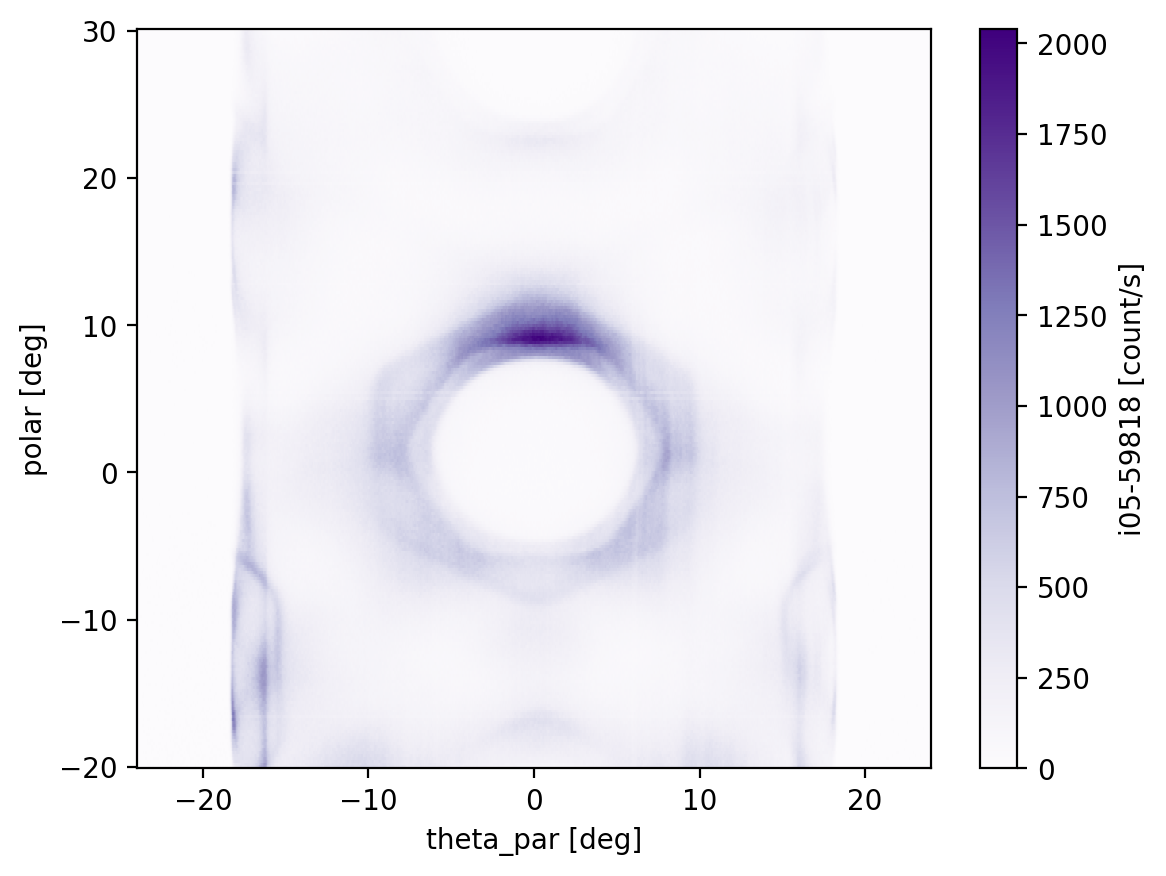

In [21]:
FS1.sum('eV').plot()

### Grouping scans

If multiple scans are loaded simultaneously, these are loaded into a :class:`xarray.DataTree` structure

In [21]:
multiple_disp

Magnitude,[[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]]
Units,count/s
Magnitude,[[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]]
Units,count/s


This can be considered as a tree-like structure, where the stored data are the leaves of the tree. A quick view of the tree structure (and included scans) can be accessed via the method `.view()`. This prints a tree structure, where items containing data are coloured in green. 

In [22]:
multiple_disp.view()


├── disp1
└── gold



Or a more detailed view via a simple `print()`

In [23]:
print(multiple_disp)

<xarray.DataTree>
Group: /
├── Group: /disp1
│       Dimensions:    (theta_par: 1000, eV: 1040)
│       Coordinates:
│         * theta_par  (theta_par) float64 8kB -23.94 -23.9 -23.85 ... 23.85 23.9 23.94
│         * eV         (eV) float64 8kB 104.5 104.5 104.5 104.5 ... 105.4 105.4 105.4
│       Data variables:
│           data       (eV, theta_par) float32 4MB [count/s] 0.0 0.0 0.0 ... 0.0 0.0 0.0
└── Group: /gold
        Dimensions:    (theta_par: 1000, eV: 1040)
        Coordinates:
          * theta_par  (theta_par) float64 8kB -23.94 -23.9 -23.85 ... 23.85 23.9 23.94
          * eV         (eV) float64 8kB 104.5 104.5 104.5 104.5 ... 105.4 105.4 105.4
        Data variables:
            data       (eV, theta_par) float32 4MB [count/s] 0.0 0.0 0.0 ... 0.0 0.0 0.0


The scan data can then be accessed using dictionary methods or an object-oriented approach

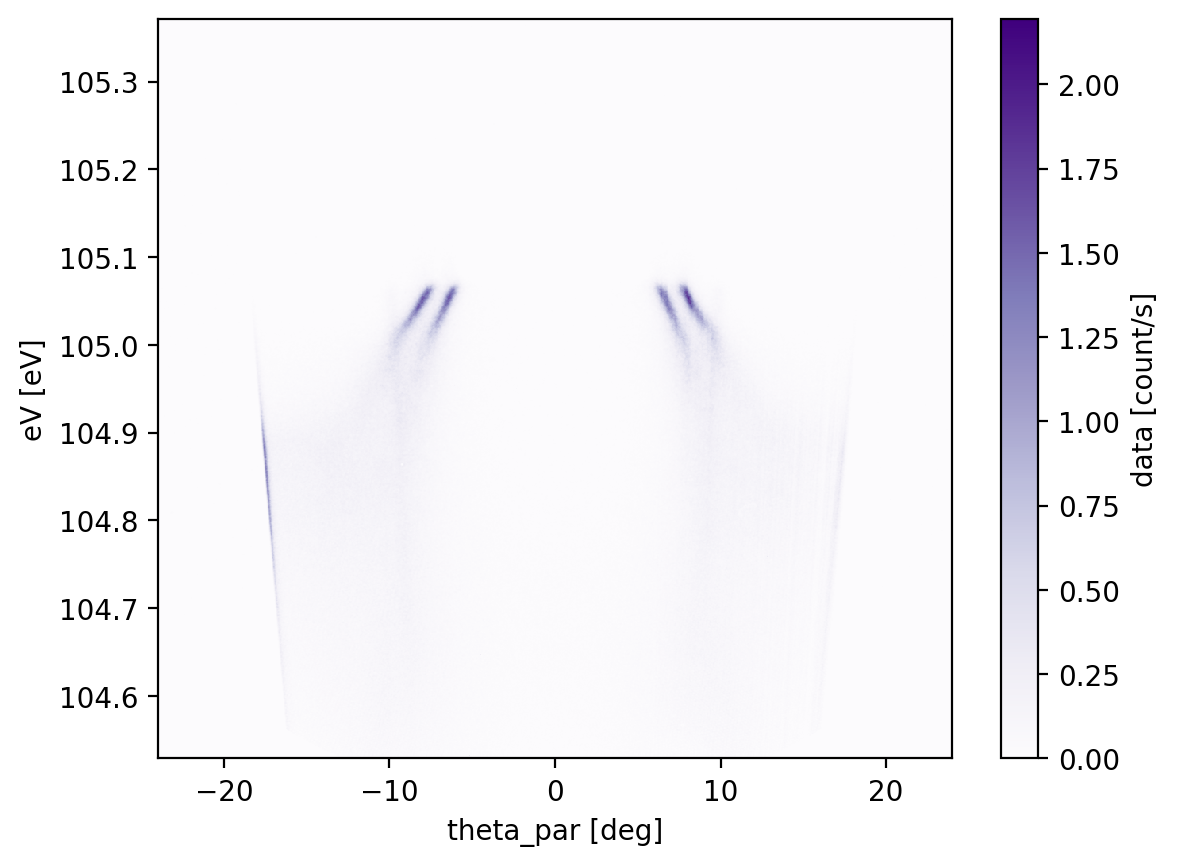

In [24]:
multiple_disp.disp1.data.plot()

:::{attention}
Note, the :class:`xarray.DataTree` structure requires data in the leaves of the tree to be in a :class:`xarray.Dataset` format, rather than a :class:`xarray.DataArray`. Unless the data is already in :class:`xarray.Dataset` form, `peaks` convention is to convert the :class:`xarray.DataArray` to a :class:`xarray.Dataset` with a single data variable `data`. Note the additional `.data` used above the access the underlying :class:`xarray.DataArray`. This :class:`xarray.DataArray` now has the name `data` rather than the default scan name. The original scan (file) name is still accessible via the [metadata](#metadata)
```python
multiple_disp.disp.scan.name
```
:::

#### Extending tree structure
A new scan group (branch of the :class:`xarray.DataTree` can be added to the tree via the helper method `.add_scan_group()`, optionally specifying a name for the group. If no name is specified a default `scan_group_#` name will be used where # is a number to make it unique. 

In [25]:

multiple_disp = pks.load([819,853], names=['disp1','gold'])

Loading data:   0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
multiple_disp.add_scan_group('FS')

In [27]:
multiple_disp.view()


├── disp1
├── gold
└── FS



Add a file to the :class:`xarray.DataTree` by passing an already loaded :class:`xarray.DataArray`, optionally providing a name for the entry in the :class:`xarray.DataTree`. Note that this is being inserted into the new scan group just created. `peaks` convention is that the :class:`xarray.DataTree` should be hollow, i.e. that data can only be added as *leafs* and not on *branches*  

In [28]:
multiple_disp['FS'].add(FS1, name='FS1')

In [29]:
multiple_disp.view()


├── disp1
├── gold
└── FS
   └── FS1



The contents of another :class:`xarray.DataTree` can be added to the original tree. Here, each scan of the new tree is added at the root level of the `multiple_disp` tree, specified by passing `add_at_root=True`. Note, this is inserted at the root level of the tree that you call `.add()` on; it may be that that actually has a parent still.

In [30]:
# Load data with specific names for the scans
dt2 = pks.load([819,853], names=['disp_copy','gold_copy'])
# Insert these scans all into the original DataTree
multiple_disp.add(dt2, add_at_root=True)

Loading data:   0%|          | 0/2 [00:00<?, ?it/s]

In [31]:
multiple_disp.view()


├── disp1
├── gold
├── FS
   └── FS1
├── disp_copy
└── gold_copy



Alternatively, they can be added as a new scan block, either with a specified name, or with an automatically generated name:

In [32]:
dt3 = pks.load([819,853])
multiple_disp.add(dt3)

Loading data:   0%|          | 0/2 [00:00<?, ?it/s]

In [33]:
multiple_disp.view()


├── disp1
├── gold
├── FS
   └── FS1
├── disp_copy
├── gold_copy
└── scan_group_0
   ├── i05_59819
   └── i05_59853



Data can also be loaded directly into the :class:`xarray.DataTree` by passing the arguments that are passed to :class:`peaks.load`

In [34]:
multiple_disp.add([819,853], name='loaded_directly', names=['disp_copy2','gold_copy2'], lazy=True)

Loading data:   0%|          | 0/2 [00:00<?, ?it/s]

<div class="alert alert-block alert-info"><b>Loading info: </b> DataArray has been lazily evaluated in the dask format (set lazy=False to load as DataArray in xarray format). Use the .compute() method to load DataArray into RAM in the xarray format, or the .persist() method to instead load DataArray into RAM in the dask format. Note: these operations load all of the data into memory, so large files may require an initial reduction in size through either a slicing or binning operation. </div>

In [35]:
multiple_disp.view()


├── disp1
├── gold
├── FS
   └── FS1
├── disp_copy
├── gold_copy
├── scan_group_0
   ├── i05_59819
   └── i05_59853
└── loaded_directly
   ├── disp_copy2
   └── gold_copy2



Individual entries or sections of the tree can be removed by a simple `del`:

In [36]:
del multiple_disp['scan_group_0']

In [37]:
multiple_disp.view()


├── disp1
├── gold
├── FS
   └── FS1
├── disp_copy
├── gold_copy
└── loaded_directly
   ├── disp_copy2
   └── gold_copy2



:::{attention}
Apart from working with hollow trees, `peaks` does not enforce a particular data structure for the :class:`xarray.DataTree` and it is at the user's discretion how to best organise their data this way. Recommended practice is to use this as a broad structure to facilitate grouping data together and for batch processing. It also provides a convenient method for saving groups of data following data processing. But the user should take care to ensure a transparent record of what processing has occured, and the underlying :class:`xarray.DataArray` (or sometimes :class:`xarray.Dataset`) remains the fundamental data unit. 
:::

## Metadata

The relevant metadata for the data is stored in the :class:`xarray.Dataarray` attributes. 
:::{tip}
While this can be modified using standard :class:`xarray` methods, in general the user should not modify the metadata directly, but rather using the provided methods described below. This has several advantages:
- it will ensure that the metadata complies with the expected `peaks` metadata structure
- it adds a transpart record to the analysis history when metadata is manually changed (see [user guide on analysis history](./4_analysis_history.ipynb)).
- it provides simple methods for updating metadata across multiple scans when stored within :class:`xarray.DataTree`'s.
:::

To show the complete set of the current metadata, simply call the `.metadata` attribute

In [40]:
disp1.metadata

scan:
    name: i05-59819
    filepath: /Users/philking/Library/CloudStorage/OneDrive-UniversityofStAndrews/Lab/Example data/i05-59819.nxs
    loc: Diamond_I05_ARPES
    timestamp: 2022-11-01 09:50:38
    scan_command: None
calibration:
    EF_correction: None
    V0: None
analyser:
    analyser:
        model: None
        slit:
            width: 0.2 mm
            identifier: None
    scan:
        eV: [104.52920499999999 105.37079499999999] eV
        step_size: 0.0008099999999999966
        PE: 10 eV
        sweeps: 600
        dwell: 1.0 s
        lens_mode: Angular30
        acquisition_mode: Fixed
        eV_type: kinetic
    angles:
        polar: None
        tilt: None
        azi: 0 deg
    deflector:
        parallel:
            local_name: deflector_y
            value: None
        perp:
            local_name: deflector_x
            value: None
manipulator:
    polar:
        local_name: sapolar
        value: 1.5015242916799991 deg
        reference_value: None
    t

The relevant keys for the metadata entries can be returned with `.keys()`:

In [41]:
disp1.metadata.keys()

dict_keys(['scan', 'calibration', 'analyser', 'manipulator', 'photon', 'temperature'])

Metadata can be shown for individual subgroups using a dot notation:

In [42]:
disp1.metadata.photon

hv: 109.999792 eV
polarisation: LH
exit_slit: 0.01 mm

and set using a simple assignment:

In [43]:
disp1.metadata.photon.hv = 110

In [44]:
disp1.metadata.photon.hv

<Quantity(110, 'electron_volt')>

In [45]:
disp1.metadata.photon

hv: 110 eV
polarisation: LH
exit_slit: 0.01 mm

Units are maintained where already existing, or can be set explicitly by passing a :class:`pint.Quantity` where the unit registry is available in the `peaks` namespace as `pks.ureg`:

In [46]:
disp1.metadata.photon.exit_slit = 10 * pks.ureg('um')

In [47]:
disp1.metadata.photon

hv: 110 eV
polarisation: LH
exit_slit: 10 µm

Metadata can also be updated by passing a dictionary which respects the structure of the metadata groups starting from the level where called:

In [48]:
disp1.metadata.analyser.deflector({'parallel': {'local_name': 'deflector_1'}, 'perp': {'local_name': 'deflector_2'}})

parallel:
    local_name: deflector_1
    value: None
perp:
    local_name: deflector_2
    value: None

Special methods for setting normal emission metadata are discussed in the [data processing guide](./3_data_processing.ipynb)

### Batch updating metadata for a DataTree
For data stored within a :class:`xarray.DataTree` structure, you can apply the `.metadata` method to all scans in the subtree below the passed tree node. This requires the metadata to be updated to be passed in a dictionary with the same nested structure as the relevant metadata structure, and requires this structure to be the same for all data within the tree. Either a single dictionary can be passed, or keyword arguments can be used to specify the metadata group to be updated. For example, for updating a single attribute of `scan` metadata:

In [49]:
multiple_disp.disp1.data.metadata.scan

name: i05-59819
filepath: /Users/philking/Library/CloudStorage/OneDrive-UniversityofStAndrews/Lab/Example data/i05-59819.nxs
loc: Diamond_I05_ARPES
timestamp: 2022-11-01 09:50:38
scan_command: None

Updating with keyword arguments

In [50]:
multiple_disp.metadata(scan={'scan_command': 'Example of updating the metadata'})

In [51]:
multiple_disp.disp1.data.metadata.scan

name: i05-59819
filepath: /Users/philking/Library/CloudStorage/OneDrive-UniversityofStAndrews/Lab/Example data/i05-59819.nxs
loc: Diamond_I05_ARPES
timestamp: 2022-11-01 09:50:38
scan_command: Example of updating the metadata

Or updating with a single `dict`:

In [52]:
multiple_disp.metadata({'scan': {'scan_command': 'Example of updating the metadata again'}})

In [53]:
multiple_disp.FS.FS1.data.metadata.scan

name: i05-59818
filepath: /Users/philking/Library/CloudStorage/OneDrive-UniversityofStAndrews/Lab/Example data/i05-59818.nxs
loc: Diamond_I05_ARPES
timestamp: 2024-10-25 04:45:11
scan_command: Example of updating the metadata again

### Setting manipulator normal emissions

Additional helper methods exist for setting normal emission values.

In [54]:
FS = FS1.MDC(105.05,0.05).compute()

[########################################] | 100% Completed | 7.52 s


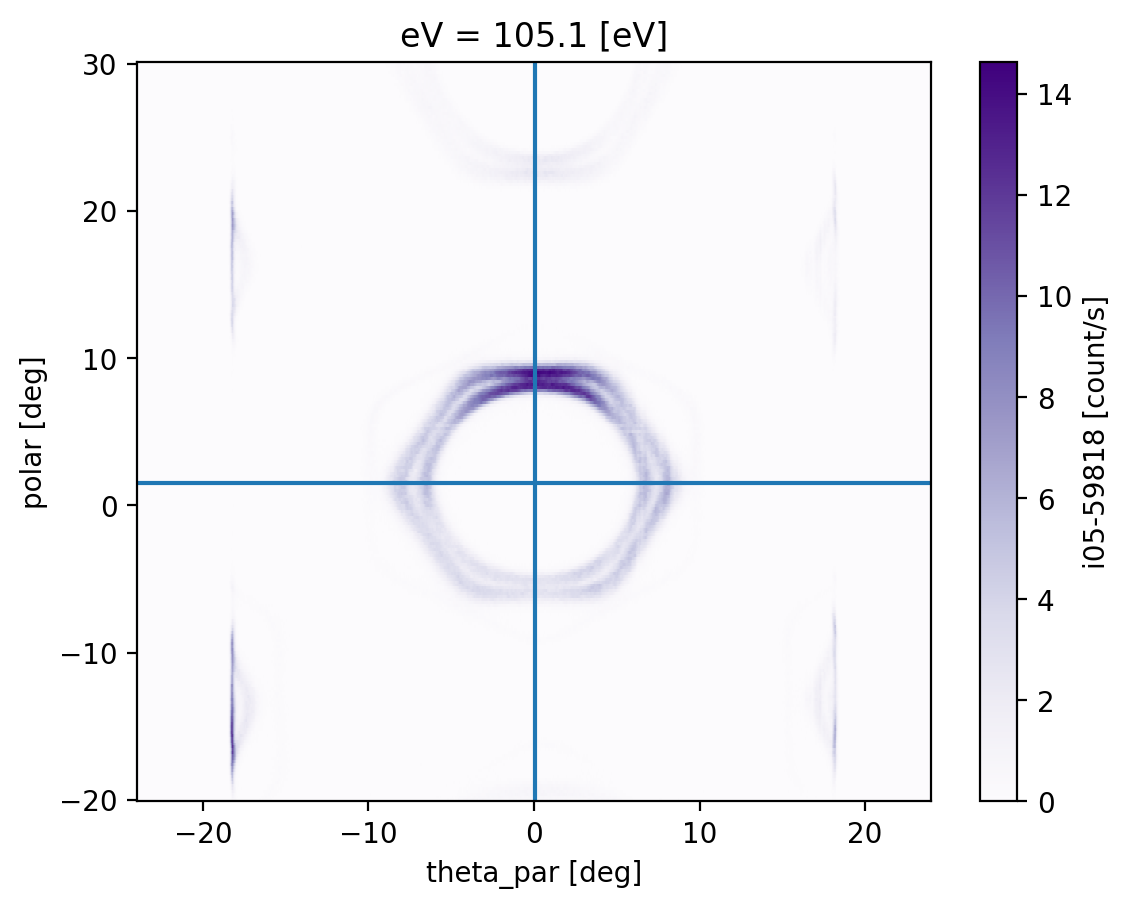

In [55]:
# Rough estimate of normal emission
FS.plot()
plt.axvline(0.05)
plt.axhline(1.5)

To set the relevant axis reference values, we can use the `.metadata.set_normal_emission()` method, passing our determined values as either a dictionary or with keyword arguments:

In [56]:
FS1.metadata.set_normal_emission(polar=1.5, theta_par=0.05)

Now reference values are set for the relevant polar and tilt axes

In [57]:
FS1.metadata.manipulator

polar:
    local_name: sapolar
    value: [-19.9992378484 30.00095257238] deg
    reference_value: 1.5 deg
tilt:
    local_name: satilt
    value: 0.006 deg
    reference_value: 0.056 deg
azi:
    local_name: saazimuth
    value: -12.510000138999999 deg
    reference_value: None
x1:
    local_name: sax
    value: 1.089 mm
    reference_value: None
x2:
    local_name: say
    value: [0.171 0.42000000000000004] mm
    reference_value: None
x3:
    local_name: saz
    value: -2.8659999999999854 mm
    reference_value: None

To set normal emission values of a scan (or an entire :class:`xarray.DataTree`) to be like another scan, use the `set_normal_emission_like` method:

In [58]:
disp1.metadata.set_normal_emission_like(FS1)

In [59]:
disp1.metadata.manipulator

polar:
    local_name: sapolar
    value: 1.5015242916799991 deg
    reference_value: 1.5 deg
tilt:
    local_name: satilt
    value: 0.006 deg
    reference_value: 0.056 deg
azi:
    local_name: saazimuth
    value: -12.510000138999999 deg
    reference_value: None
x1:
    local_name: sax
    value: 1.09 mm
    reference_value: None
x2:
    local_name: say
    value: 0.278 mm
    reference_value: None
x3:
    local_name: saz
    value: -2.8659999999999854 mm
    reference_value: None

### Analysis history
To enhance the reproducibility and data provenance for data analysed using `peaks`, we attempt to keep track of data operations performed using in-built `peaks` functions (including the name of the calling function), and store these in a JSON-type record within the data attributes of the :class:`xarray.DataArray`, under the entry `analysis_history`. While a well-organised Jupyter notenbook is a good start, the user has to be careful to only execute cells in order, and a typical analysis workflow may involve loading and processing some data and saving an intermediate step, before further post-processing in another notebook, necessating a richer storing of data analysis history. Saving and loading using in-built peaks methods will attempt to keep a persistent data analysis record in tact. The analysis history can also show up where some additional methods (e.g. automatic Fermi level estimation) have been called as part of the pipeline.


In [60]:
with pks.opts as opts:
    opts.FileIO.path = os.path.join('/Users/Shared/','i05-59')
    opts.FileIO.ext = 'nxs'

    disp2 = pks.load(819)

An initial history record is made upon loading, which can be accessed via the `.history()` accessor. This attempts to display the history in a formatted table: 

In [61]:
disp2.history

,time,peaks version,record,function name
0,2024-11-09 15:57:13.066085,0.3.0-dev,"{'record': 'Data loaded', 'loc': 'Diamond_I05_ARPES', 'loader': 'I05ARPESLoader', 'file_name': '/Users/Shared/i05-59819.nxs'}",_add_load_history


History as of 24-11-09 15-57-13

`peaks` functions typically add brief history records, including when metadata is updated using the methods discussed [above](#metadata).

In [62]:
disp2.metadata.scan.name = 'test example'

In [63]:
disp2.history

,time,peaks version,record,function name
0,2024-11-09 15:57:13.066085,0.3.0-dev,"{'record': 'Data loaded', 'loc': 'Diamond_I05_ARPES', 'loader': 'I05ARPESLoader', 'file_name': '/Users/Shared/i05-59819.nxs'}",_add_load_history
1,2024-11-09 15:57:17.709529,0.3.0-dev,Metadata attribute 'scan.name' was manually set to test example,.metadata


History as of 24-11-09 15-57-18

Some records cam get a little complicated, so a single record can be printed in a clearer format by calling the history accessor with an index of the record to display (defaults to the last record if nothing is passed)

In [64]:
disp2.history(0)

{'function name': '_add_load_history',
 'peaks version': '0.3.0-dev',
 'record': {'file_name': '/Users/Shared/i05-59819.nxs',
            'loader': 'I05ARPESLoader',
            'loc': 'Diamond_I05_ARPES',
            'record': 'Data loaded'},
 'time': datetime.datetime(2024, 11, 9, 15, 57, 13, 66085)}


The corresponding dictionary can be returned, rather than just printed, if calling with the `.get(index)` method, or a list of all entries can be returned if calling with no specified index:

In [65]:
disp2.history.get()

[{'time': datetime.datetime(2024, 11, 9, 15, 57, 13, 66085),
  'peaks version': '0.3.0-dev',
  'record': {'record': 'Data loaded',
   'loc': 'Diamond_I05_ARPES',
   'loader': 'I05ARPESLoader',
   'file_name': '/Users/Shared/i05-59819.nxs'},
  'function name': '_add_load_history'},
 {'time': datetime.datetime(2024, 11, 9, 15, 57, 17, 709529),
  'peaks version': '0.3.0-dev',
  'record': "Metadata attribute 'scan.name' was manually set to test example",
  'function name': '.metadata'}]

#### Saving analysis history
A json string of the entire analysis history record can be returned using the `history.json` method, and saved using `history.save()`. It can then be opened in the standard way, or e.g. viewed in a web browser or other software. The metadata record is also saved as part of the data if saving using the :class:`peaks` :class:`peaks.save` and :class:`peaks.load` functions

In [66]:
# Save the history metadata only
disp2.history.save('saving_analysis_metadata.json')

#### Manually adding analysis history

Most `peaks`-specific functions aim to add a related history record, which is one reason to use these functions even where they are otherwise only thin wrappers around e.g. existing :class:`xarray functions`. Operating on a :class:`xarray.DataArray` with e.g. a built in :class:`xarray` method or other non `peaks`-specific function will not lead to the analysis record being updated. In such cases, you should manaully update the analysis record using `.history.add()`

In [67]:
# Manually change one of the dispersions
disp2 *= 10

# Add the history record
disp2.history.add('Data intensity multiplied by 10', fn_name='Manual record')

In [68]:
disp2.history

,time,peaks version,record,function name
0,2024-11-09 15:57:13.066085,0.3.0-dev,"{'record': 'Data loaded', 'loc': 'Diamond_I05_ARPES', 'loader': 'I05ARPESLoader', 'file_name': '/Users/Shared/i05-59819.nxs'}",_add_load_history
1,2024-11-09 15:57:17.709529,0.3.0-dev,Metadata attribute 'scan.name' was manually set to test example,.metadata
2,2024-11-09 15:57:26.644853,0.3.0-dev,Data intensity multiplied by 10,Manual record


History as of 24-11-09 15-57-27

This methodology can be used within a custom function, where `peaks` will attempt to also capture the name of the calling function. The data can either be updated in place (behaviour when calling with the `.add` accessor) or a copy of the data with modified history metadata can be returned using the `.assign()` accessor, to aid in chaining methods together (similar to the :class:`xarray.DataArray.assign_attrs` and :class:`xarray.DataArray.assign_coords` methods).

:::{warning}
It is easy to accidentally update the analysis history of the underlying :class:`xarray.DataArray` that was passed to the function. This should be carefully checked to ensure the desired operation.
:::

In [69]:
def add_one(data):
    data = data.history.assign('Added one to the original data')
    return data + 1*pks.ureg('count/s')

In [70]:
disp3 = add_one(disp2)

In [71]:
disp3.history

,time,peaks version,record,function name
0,2024-11-09 15:57:13.066085,0.3.0-dev,"{'record': 'Data loaded', 'loc': 'Diamond_I05_ARPES', 'loader': 'I05ARPESLoader', 'file_name': '/Users/Shared/i05-59819.nxs'}",_add_load_history
1,2024-11-09 15:57:17.709529,0.3.0-dev,Metadata attribute 'scan.name' was manually set to test example,.metadata
2,2024-11-09 15:57:26.644853,0.3.0-dev,Data intensity multiplied by 10,Manual record
3,2024-11-09 15:57:28.379172,0.3.0-dev,Added one to the original data,add_one


History as of 24-11-09 15-57-29

For simple cases like the above, where e.g. no parameters to pass to the history string need to be determined during the function execution, a decorator method can be used:

In [72]:
from peaks.core.metadata.history import update_history_decorator

@update_history_decorator('Added two to the data')
def add_two(data):
    return data + 2*pks.ureg('count/s')

In [73]:
disp3 = add_two(disp2)

In [74]:
disp3.history

,time,peaks version,record,function name
0,2024-11-09 15:57:13.066085,0.3.0-dev,"{'record': 'Data loaded', 'loc': 'Diamond_I05_ARPES', 'loader': 'I05ARPESLoader', 'file_name': '/Users/Shared/i05-59819.nxs'}",_add_load_history
1,2024-11-09 15:57:17.709529,0.3.0-dev,Metadata attribute 'scan.name' was manually set to test example,.metadata
2,2024-11-09 15:57:26.644853,0.3.0-dev,Data intensity multiplied by 10,Manual record
3,2024-11-09 15:57:30.116222,0.3.0-dev,Added two to the data,add_two


History as of 24-11-09 15-57-30

## Saving data
Data can be saved using the `.save()` accessor. A single :class:`xarray.DataArray` or :class:`xarray.Dataset` is saved in a netCDF file (extension `.nc`) and a :class:`xarray.DataTree` is stored in a Zarr file (extension `.zarr`). Any metadata attributes stored using `peaks` methods should be serialised and re-openeded correctly, at least if using the same version of `peaks`. If other metadata has been stored in the attributes, this may not be parsed properly depending on the data type.

In [74]:
disp1.save('disp1.nc')

In [75]:
multiple_disp.save('dt_example.zarr')

[########################################] | 100% Completed | 6.31 s


These can then be loaded again using the regular :class:`peaks.load` method

In [76]:
new_disp1 = pks.load('disp1.nc')

In [77]:
new_dt = pks.load('dt_example.zarr')

<div class="alert alert-block alert-info"><b>Loading info: </b> The data is lazily loaded by default for loading from a Zarr store. Use the .compute() method on the individual data entries to load each into memory. To eagerly load the entire DataTree, pass the `lazy=False` argument to the load function. Ensure that the total data contents is not too large to fit in memory. </div>